In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.html import widgets
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np

In [10]:
from ksptools import get_engines, Engine, g0

engines = get_engines(ksp_dir=".")

rows = [[str(getattr(e,field)) for field in Engine._fields] for e in engines]
rows.insert(0, Engine._fields)
cols = zip(*rows)
col_widths = [max(len(value) for value in col) for col in cols]

fmt = ' '.join(['{{:<{}}}'.format(width) for width in col_widths])
for row in rows:
  print fmt.format(*row)


skipping J-X4 "Whiplash" Turbo Ramjet Engine due to <type 'exceptions.NotImplementedError'>
skipping J-33 "Wheesley" Basic Jet Engine due to <type 'exceptions.NotImplementedError'>
skipping CR-7 R.A.P.I.E.R. Engine due to <type 'exceptions.NotImplementedError'>
name                                       mass   fvac   isp                                         isp_func                                                    
Sepratron I                                0.0125 18.0   [(0.0, 154.0), (1.0, 118.0), (6.0, 0.001)]  <numpy.lib.function_base.vectorize object at 0x7fd38a02c890>
LV-1R "Spider" LFE                         0.02   2.0    [(0.0, 290.0), (1.0, 260.0), (8.0, 0.001)]  <numpy.lib.function_base.vectorize object at 0x7fd38a02c710>
LV-1 "Ant" LFE                             0.02   2.0    [(0.0, 315.0), (1.0, 85.0), (3.0, 0.001)]   <numpy.lib.function_base.vectorize object at 0x7fd38a02c7d0>
24-77 "Twitch" LFE                         0.09   16.0   [(0.0, 290.0), (1.0, 250.0), (7.0

In [5]:
slider_mintwr = widgets.FloatSlider(value=1., min=0., max=5., description="Minimum thrust-to-weight ratio")
display(slider_mintwr)
slider_pressure = widgets.FloatSlider(value=1., min=0., max=5., description="Pressure in atm")
display(slider_pressure)
button_go = widgets.Button(description="test")
display(button_go)

Saving figure...
Done.


/usr/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


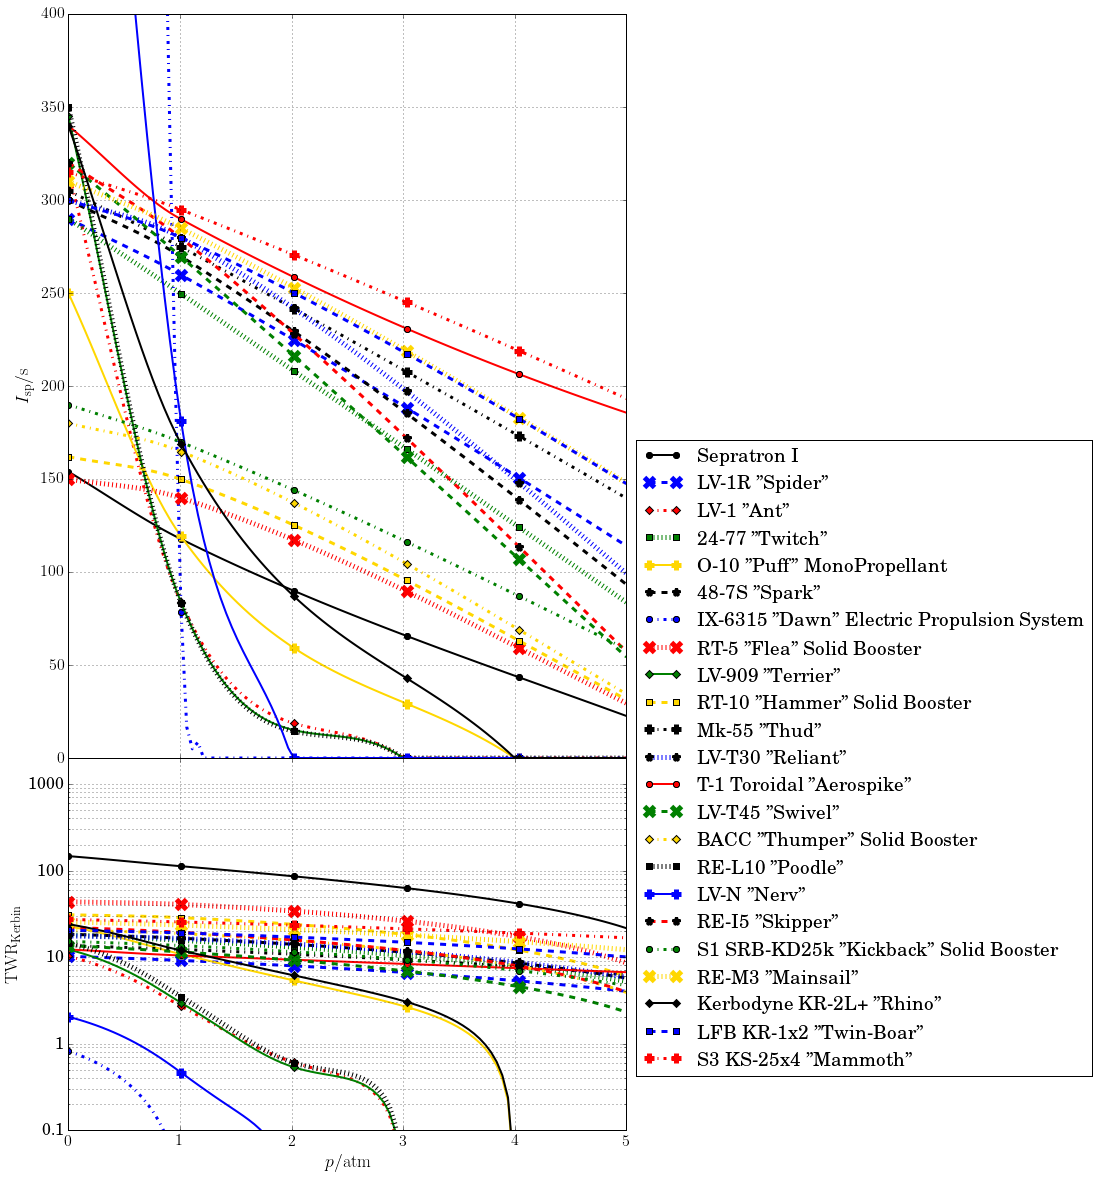

In [5]:
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif', size=16)
import matplotlib.pyplot as plt
import numpy as np

from itertools import cycle
lss = ["-","--","-.",":"]
lscycle = cycle(lss)
lwcycle = cycle([2, 3, 3, 5])
colours = cycle(['black', 'blue', 'red', 'green', 'gold'])
colcycle = cycle(colours)
mkcycle = cycle(['o', 'x', 'D', 's', '+', '*'])
mscycle = cycle([6, 10, 6, 6, 10, 8])

fig, (ax_isp, ax_f) = plt.subplots(2, sharex=True, figsize=(10,20), gridspec_kw={"height_ratios": (2,1)})
for e in engines:
    ls = next(lscycle)
    lw = next(lwcycle)
    color = next(colcycle)
    marker = next(mkcycle)
    markersize = next(mscycle)
    mew=markersize-5
               
    p = np.linspace(0, 5, 100)
    isp = e.isp_func(p)
    f = e.fvac/e.isp_func(0) * isp 
    twr = f/(e.mass * g0)
    ax_isp.plot(p, isp, label=e.name, ls=ls, lw=lw, color=color,marker=marker,markersize=markersize,mew=mew,markevery=20)
    ax_f.plot(p, twr, ls=ls, lw=lw, color=color, marker=marker,markersize=markersize,mew=mew,markevery=20)
    #ax_f.plot(p, f, ls=ls, lw=lw, color=color)
    
fig.subplots_adjust(hspace=0)
ax_isp.set_ylabel(r"$I_{\mathrm{sp}}/\mathrm{s}$", fontsize=18)
ax_f.set_ylabel(r"$\mathrm{TWR_{Kerbin}}$", fontsize=18)
#ax_f.set_ylabel(r"$F_\mathrm{thrust}/\mathrm{kN}$", fontsize=18)
ax_f.set_xlabel(r"$p/\mathrm{atm}$", fontsize=18)
lgd = ax_isp.legend(loc='center left', bbox_to_anchor=(1, 0))
ax_isp.grid(True)
ax_isp.set_ylim([0, 400])
ax_f.set_ylim([0.1, 2000])
ax_f.set_yscale("log")
ax_f.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.4G'))
ax_f.grid(True, which='both')

print "Saving figure..."
fig.savefig("engines_pressure2.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig("engines_pressure2.svg", bbox_extra_artists=(lgd,), bbox_inches='tight')
print "Done."

fig.show()


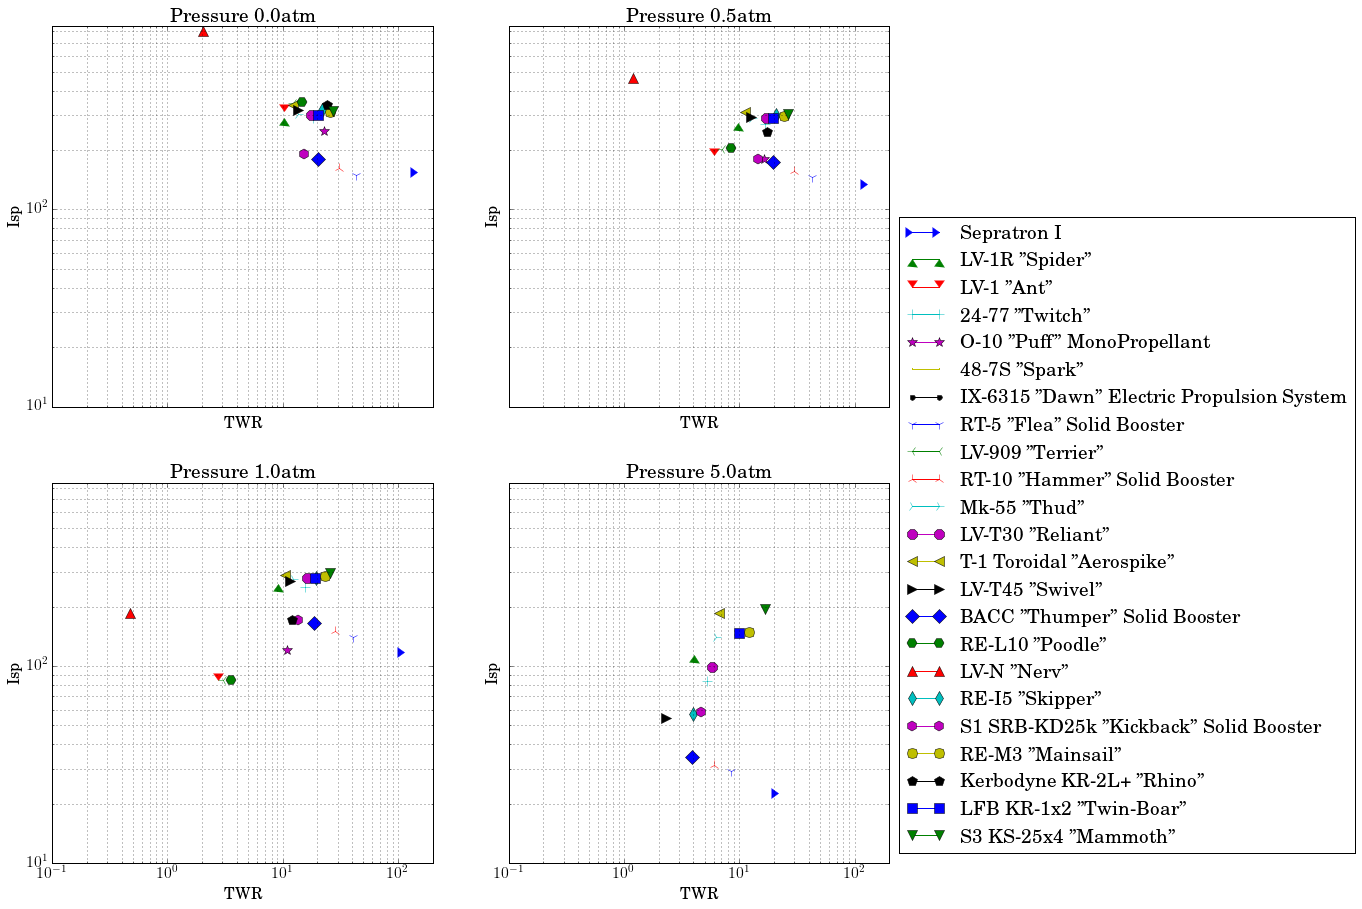

In [6]:
import matplotlib.pyplot as plt

markers = {u'D': u'diamond', 6: u'caretup', 7: u'caretdown', u's': u'square', u'|': u'vline', u'x': u'x', 5: u'caretright', u'^': u'triangle_up', u'd': u'thin_diamond', u'h': u'hexagon1', u'+': u'plus', u'*': u'star', u',': u'pixel', u'o': u'circle', u'.': u'point', u'1': u'tri_down', u'p': u'pentagon', u'3': u'tri_left', u'2': u'tri_up', u'4': u'tri_right', u'H': u'hexagon2', u'v': u'triangle_down', u'8': u'octagon', u'<': u'triangle_left', u'>': u'triangle_right'}
markers = list(markers.keys())

ps = [0., 0.5, 1., 5.] 
isps = [e.isp_func(ps) for e in engines]
thrust = [(e.fvac/e.isp_func(0)) * e.isp_func(ps) for e in engines]
twrs = [(e.fvac/e.isp_func(0)) * e.isp_func(ps) / (g0 * e.mass) for e in engines] 

fig, axs = plt.subplots(2,2,figsize=(15,15), sharex=True, sharey=True)
axs = axs.reshape(-1)


for i,(isp, twr) in enumerate(zip(isps,twrs)):
    e = engines[i]
    for i_p, p in enumerate(ps):
        axs[i_p].plot([twr[i_p]],[isp[i_p]], ms=10, marker=markers[i], label=e.name)


lgd = plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

for i, ax in enumerate(axs):
    ax.set_title("Pressure "+str(ps[i])+"atm")
    ax.set_ylabel("Isp")
    ax.set_xlabel("TWR")
    ax.set_xlim((0.1, 200))
    ax.set_ylim((10, 850))
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.grid(which="both")

fig.savefig("isp_twr.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

$\texttt{ksptools.py}$
===

The function $\texttt{n_e}$
---------

Calculates the number of engines $n_\mathrm{e}$ needed for a certain thrust to weight ratio $\mathrm{TWR}$ for a payload mass $m_\mathrm{p}$ with a certain $\Delta v$. This takes into account the fuel mass required for that $\Delta v$. 

### The maths
Tsiolkovsky rocket equation:

$$\Delta v = u \ln \left( \frac{m_\mathrm{dry} + m_\mathrm{fuel}}{m_\mathrm{dry}} \right)$$

where $u = I_\mathrm{sp} \cdot g_0$ is the exhaust velocity, $I_\mathrm{sp}$ is the specific impulse, $g_0 = 9.81 \mathrm{\frac{m}{s^2}}$ is the standard gravity.

$m_\mathrm{dry}$ is just the sum of the total mass of the engines $n_\mathrm{e} \cdot m_\mathrm{e}$ and the payload mass $m_\mathrm{p}$. Together with $m_\mathrm{fuel}$ this is just the launch mass.

We rewrite the above as 

$$e^\frac{\Delta v}{u} = \frac{n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p} + m_\mathrm{fuel}}{n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p}} = \frac{m_\mathrm{launch}}{n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p}}$$

Given that the thrust to weight ratio $\mathrm{TWR} = \frac{F_\mathrm{thrust}}{g_0 \cdot m_\mathrm{launch}}$ should be greater than some minimum $\mathrm{TWR} \geq \mathrm{TWR_{min}}$, this becomes ($F_\mathrm{thrust} = n_\mathrm{e} F_\mathrm{thrust,e}$)

$$e^\frac{\Delta v}{u} = \frac{ \frac{n_\mathrm{e} F_\mathrm{thrust,e}}{g_0 \cdot \mathrm{TWR}}}{n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p}} \leq \frac{ \frac{n_\mathrm{e} F_\mathrm{thrust,e}}{g_0 \cdot \mathrm{TWR_{min}}}}{n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p}}$$

which we can with some symbol juggling rearrange into

$$n_\mathrm{e} \geq \frac{m_\mathrm{p}}{\frac{F_\mathrm{thrust}}{g_0 \mathrm{TWR_{min}} e^{\Delta v / u}} - m_\mathrm{e}} $$

The function $\texttt{compute}$
---------

Starting from the result $n_e$ we can calculate the total mass of the craft that has the $\Delta v$ for the payload mass $m_\mathrm{p}$ we are looking for.

### The maths

Recall from above, that

$$e^\frac{\Delta v}{u} = \frac{n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p} + m_\mathrm{fuel}}{n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p}}$$

which can be easily written as


$$\left( n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p} \right) e^\frac{\Delta v}{u} = n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p} + m_\mathrm{fuel} = m_\mathrm{launch}$$

This means that for a given number of engines $n_\mathrm{e}$, Engine type ($I_\mathrm{sp}$, $F_\mathrm{thrust}$, $m_\mathrm{e}$) and target $\Delta v$ with payload mass $m_\mathrm{p}$, we can find the total mass of the craft.

### But what does it mean?

We do this for all engines, and the craft with the least mass is the best. Why, you may ask? Because one stage's mass is a lower stage's payload mass. And you see that exponential in there? That gets really ugly, really quickly. So the best stage configuration is that with the least total mass needed for the $\Delta v$ you wish to achieve for a payload mass.





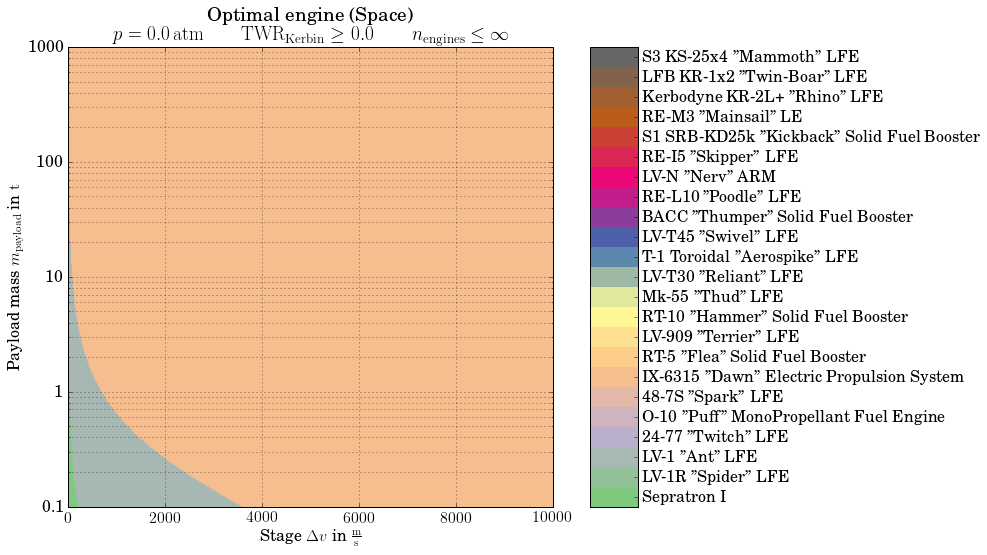

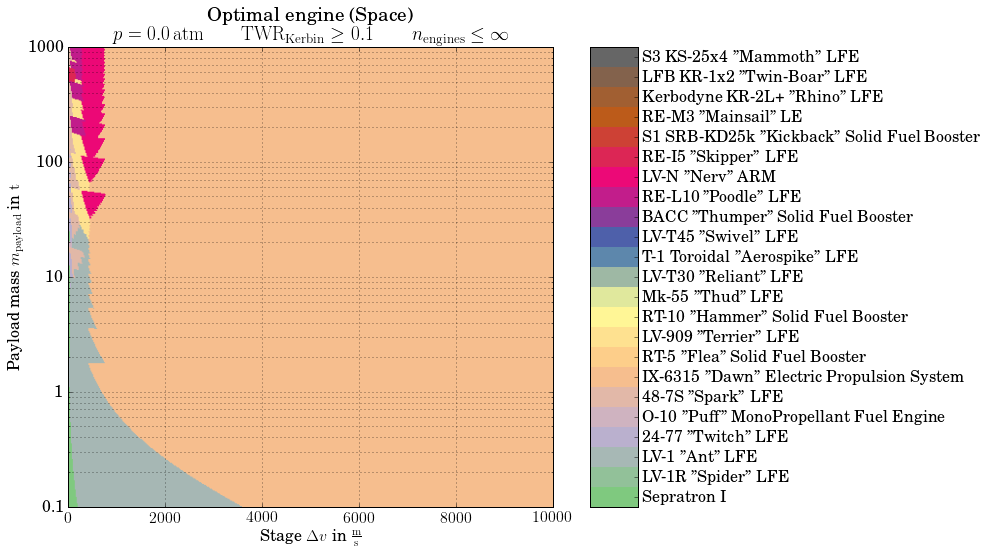

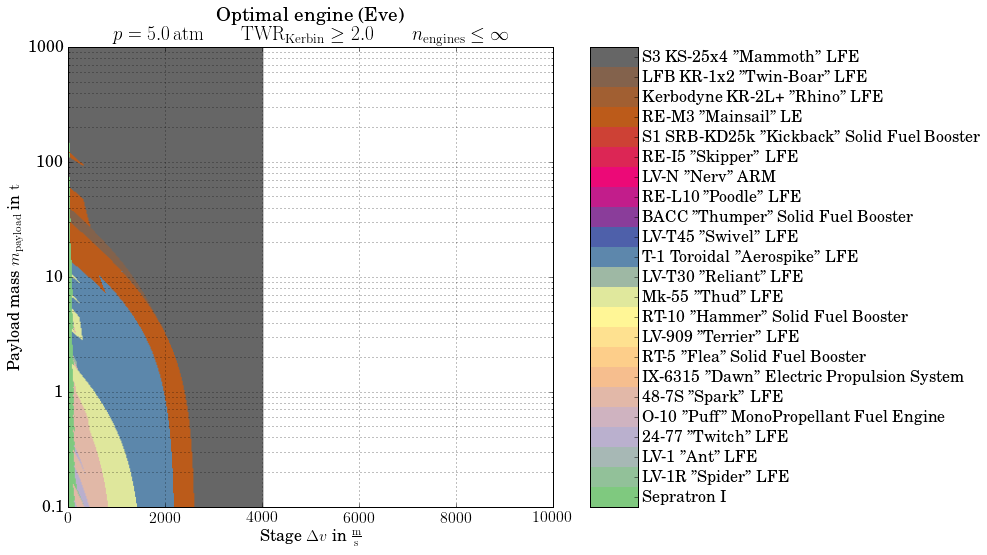

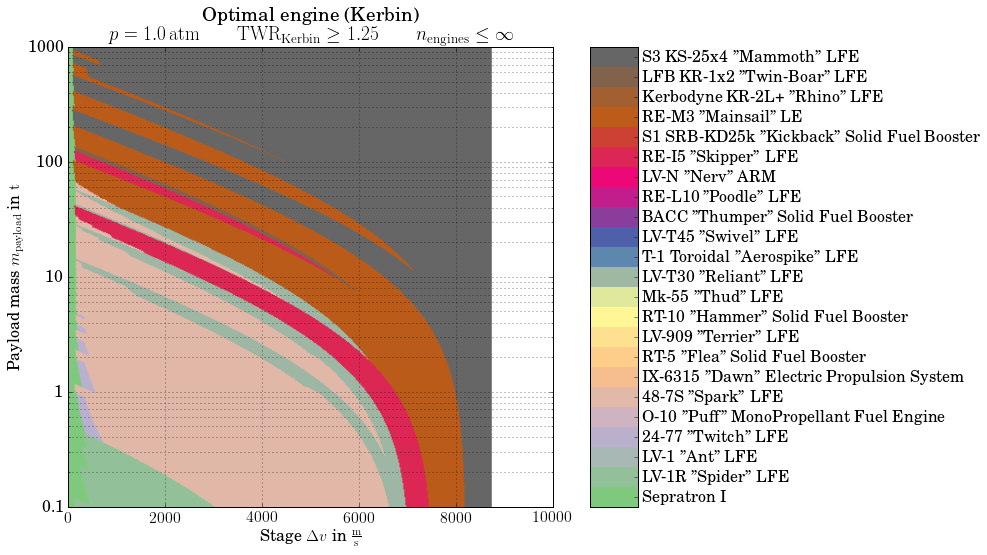

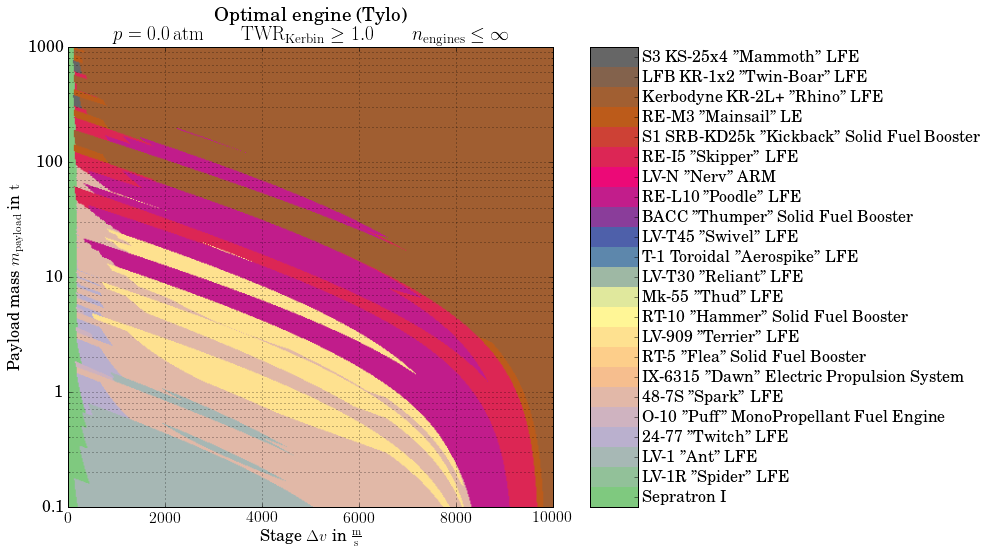

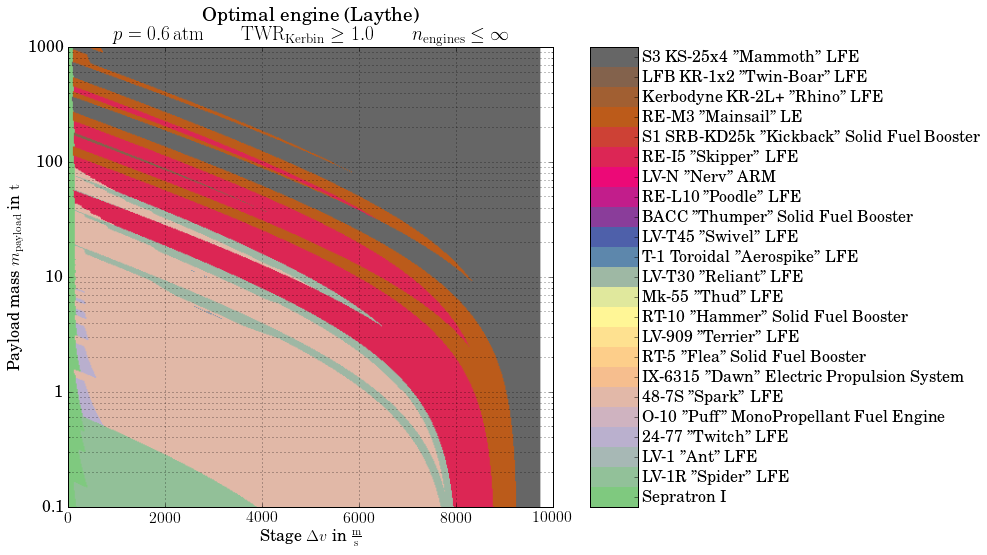

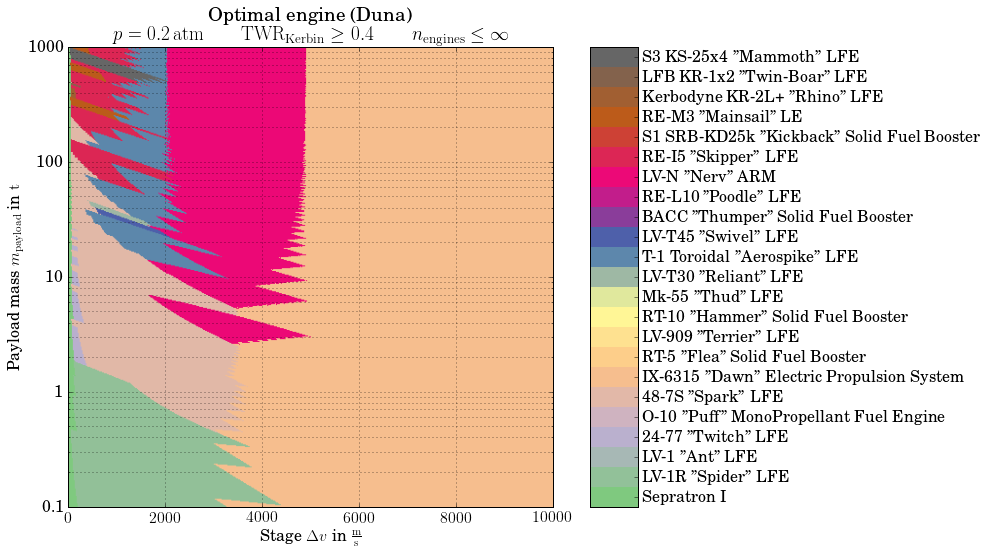

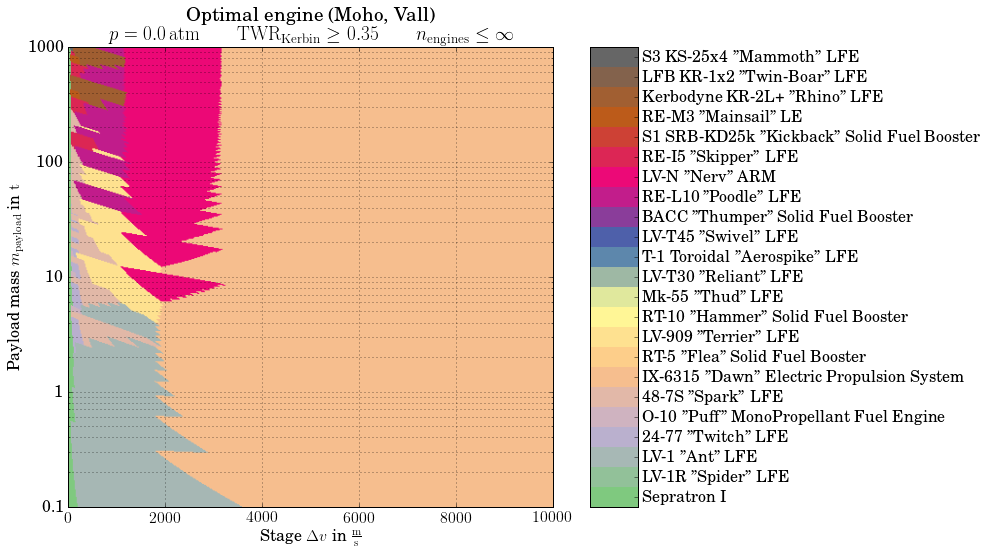

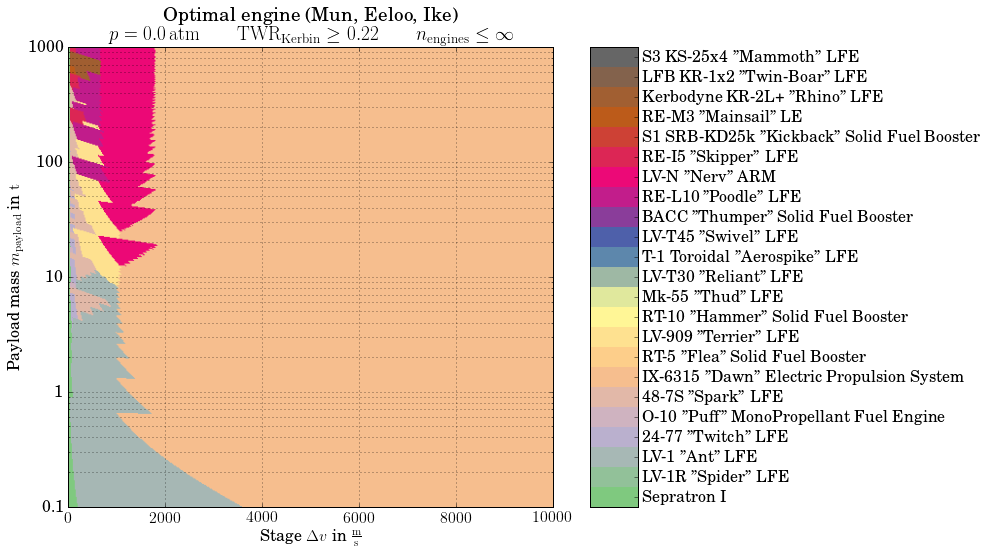

In [141]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from ksptools import compute

mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif', size=16)

arg_names = ('min_twr', 'pressure', 'max_engine_count', 'name')
plot_args = [(0., 0., np.inf, "Space"),
             (.1, 0., np.inf, "Space"),
             (2., 5., np.inf, "Eve"),
             (1.25, 1., np.inf, "Kerbin"),
             (1., 0., np.inf, "Tylo"),
             (1., 0.6, np.inf, "Laythe"),
             (.4, 0.2, np.inf, "Duna"),
             (.35, 0., np.inf, "Moho, Vall"),
             (.22, 0., np.inf, "Mun, Eeloo, Ike")]
plot_kwargs = [dict(zip(arg_names, args)) for args in plot_args]

dv_min=0.; dv_max=10000.
m_p_min=0.1; m_p_max=1000.
res = (500,500)

# Add iterating arrays
#dv = np.arange(xmin, xmax, xmax/res[0]) #Δv
dv = np.linspace(dv_min, dv_max, num=res[0]) #Δv
m_p = np.logspace(np.log10(m_p_min), np.log10(m_p_max), num=res[1]) #payload mass
Dv, M_p = np.meshgrid(dv, m_p)

for kwargs in plot_kwargs:
    n, M, I = compute(engines, (Dv, M_p), **kwargs)
    
    #print "Plotting..."
    fig, (ax, axcb) = plt.subplots(1, 2,figsize=(14,8), gridspec_kw={"width_ratios": (10,1)})
    ax.set_title((r"Optimal engine ({name})"+"\n"+
                  r"$p={pressure!s}\,\mathrm{{atm}}$\qquad"
                  r"$\mathrm{{TWR_{{Kerbin}}}} \geq {min_twr!s}$\qquad" 
                  r"$n_\mathrm{{engines}} \leq {max_engine_count!s}$").format(**kwargs).replace(r'inf',r'\infty'))

    cmap_tmp = mpl.pyplot.cm.Accent
    cmaplist_tmp = [cmap_tmp(i) for i in range(cmap_tmp.N)]
    cmaplist_tmp[85] = (0.2,0.7,0.9,1.0)
    norm_eng = mpl.colors.BoundaryNorm(np.arange(len(engines)+1), cmap_tmp.N)
    cmap_eng = cmap_tmp.from_list('Custom cmap', cmaplist_tmp, cmap_tmp.N)
    cmap_eng.set_over('white')

    #plt.contour
    
    ax.set_yscale('log')
    ax.grid(True, which="both")   
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.4G'))
    ax.set_ylabel(r'Payload mass $m_\mathrm{payload}$ in $\mathrm{t}$')
    ax.set_xlabel(r'Stage $\Delta v$ in $\mathrm{\frac{m}{s}}$') 

    ax.imshow(I, extent=(dv_min,dv_max,m_p_min,m_p_max), origin="lower", cmap=cmap_eng, norm=norm_eng)
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap_eng, norm=norm_eng, format=None, extend="neither", ticks=np.arange(len(engines))+0.5)                
    cb.ax.set_yticklabels([e.name for e in engines])
    
    # plot n_engines
    '''
    n_inv = np.inf*np.ones(I.shape) #set to inf for out of bounds
    n_inv = np.expand_dims(n_inv,0) #to be able to concatenate, match dims
    n_ext = np.concatenate((n,n_inv)) #concatenate inf

    y,z = np.meshgrid(np.arange(n.shape[1]),np.arange(n.shape[2]), indexing='ij')
    n_oe = n_ext[I,y,z]
    #ax.imshow(n_oe, extent=(xmin,xmax,ymin,ymax), origin="lower")
    contour = ax.contour(Dv, M_p, n_oe)
    ax.clabel(contour, contour.levels, fmt=r"$n_\mathrm{engines}=%i$")
    '''
    
    #print "Done."
    fig.tight_layout()
    fig.savefig("optimalengine_{name}_p={pressure!s}_nmax={max_engine_count!s}_mintwr={min_twr!s}.png".format(**kwargs))
    plt.show()

plotting IX-6315 "Dawn" Electric Propulsion System 0.25


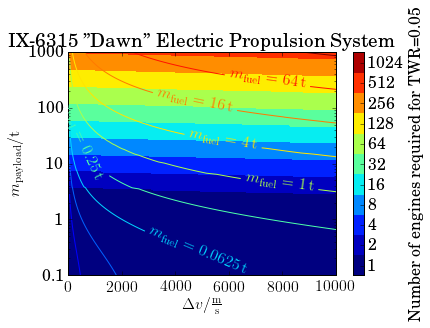

In [142]:
from ksptools import n_e

res = (200, 200)
dv = np.linspace(dv_min, dv_max, num=res[0]) #Δv
m_p = np.logspace(np.log10(m_p_min), np.log10(m_p_max), num=res[1]) #payload mass
Dv, M_p = np.meshgrid(dv, m_p)

cmap = plt.get_cmap('jet')
#mpl.colors.ListedColormap(['blue', 'green', 'red'])
#bounds=[0,1.1,2.1, 10]
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

e = engines[6]
min_twr = .05
print "plotting",e.name, e.mass
n_engines = n_e(e, (Dv, M_p), min_twr=min_twr)
m_fuel = (M_p + n_engines*e.mass)*(np.exp(Dv/(e.isp_func(0)*g0))-1)
m_tot = m_fuel + M_p + n_engines*e.mass
ax = plt.contourf(Dv, M_p, n_aerospike, locator=mpl.ticker.LogLocator(base=2.), vmin=1)
plt.yscale("log")
cb = plt.colorbar(format=mpl.ticker.ScalarFormatter(), label="Number of engines required for TWR={}".format(min_twr))
ticks = np.array([1,2,4,8,16,32,64,128,256,512,1024])
cb.set_ticks(ticks*np.log(2))
cb.set_ticklabels(ticks)
plt.xlabel(r"$\Delta v / \mathrm{\frac{m}{s}}$")
plt.ylabel(r"$m_\mathrm{payload} / \mathrm{t}$")
plt.title(e.name)
plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.4G'))

c_fuelmass = plt.contour(Dv, M_p, m_fuel, locator=mpl.ticker.LogLocator(base=2.))
plt.clabel(c_fuelmass, fmt=r"$m_\mathrm{fuel}=%.4G\,\mathrm{t}$")

#c_totmass = plt.contour(Dv, M_p, m_tot, locator=mpl.ticker.LogLocator(base=2.))
#plt.clabel(c_totmass, fmt=r"$m_\mathrm{tot}=%.4G\,\mathrm{t}$")

plt.show()
#for ni in np.nditer(n_aerospike)